In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
import tqdm
from tqdm import tqdm
import multiprocessing as mp
import seaborn as sns
import pickle

from cvx.stat_arb.ccp import *
from cvx.stat_arb.utils import *
from cvx.stat_arb.backtest import *

sns.set()

%load_ext autoreload
%autoreload 2

In [2]:
prices = pd.read_csv("../data/prices_500_cleaned.csv", index_col=0, header=0, parse_dates=True)
prices.columns = prices.columns.astype(int)
prices = prices.dropna(axis=1, how='any')

# Remove Berkshire Hathaway
prices = prices.drop([540], axis=1)

# Load sector_to_asset and asset_to_sector from file
with open('../data/sector_to_asset.pkl', 'rb') as f:
    sector_to_asset = pickle.load(f)
with open('../data/asset_to_sector.pkl', 'rb') as f:
    asset_to_sector = pickle.load(f)

# assets = sector_to_asset["Finance and Insurance"]
# assets = [asset for asset in assets if asset in prices.columns]
# prices = prices[assets]

# prices = prices[assets]

# Dynamically managing statistical arbitrages approach

### Find stat arbs and portfolios dynamically

In [71]:
all_prices_test[0]

,7,20678,8048,21018,21305,21880,20792,21446,20436,46699,...,21332,20363,50481,15506,32191,9764,54695,21168,40143,3178
date,,,,,,,,,,,,,,,,,,,,,
2015-01-29,118.90,87.58,42.01,102.38,52.76,87.72,24.08,85.67,55.67,201.99020,...,43.03,38.98,206.20000,75.76,86.32,20.18,22.85,26.900,38.94,37.97
2015-01-30,117.16,87.42,40.40,100.14,51.92,84.98,23.89,84.29,54.38,199.45000,...,44.03,38.96,205.53000,73.87,82.85,19.48,23.74,26.900,37.19,36.87
2015-02-02,118.63,89.58,41.28,100.83,52.81,85.71,24.21,85.12,55.47,201.92000,...,45.19,39.68,206.96001,68.72,85.15,19.74,24.45,27.910,37.54,37.57
2015-02-03,118.65,92.25,41.60,102.46,53.45,86.19,24.47,85.95,56.72,204.84000,...,46.78,40.60,207.80000,68.52,90.09,20.46,26.71,28.065,38.69,38.12
2015-02-04,119.56,91.46,41.84,101.36,53.03,86.65,24.16,85.79,56.38,204.06000,...,45.47,40.49,209.67999,68.33,89.00,19.87,25.24,27.925,39.11,37.66
2015-02-05,119.94,92.36,42.45,102.46,53.67,87.28,24.50,86.70,56.77,206.12000,...,47.22,40.76,211.02000,67.39,89.00,20.33,25.60,27.990,38.96,37.95
2015-02-06,118.93,91.50,42.41,101.10,54.45,87.33,24.52,85.61,57.89,205.55000,...,46.88,40.50,212.11000,65.89,89.72,19.96,25.68,28.215,39.22,38.00
2015-02-09,119.72,91.56,42.36,99.78,54.21,85.91,24.64,85.05,57.82,204.63000,...,46.20,41.85,207.87000,63.74,90.97,19.59,26.12,27.910,39.24,37.65
2015-02-10,122.02,91.01,42.60,100.35,54.57,87.29,24.72,85.39,58.46,206.81000,...,46.13,42.33,207.89999,65.02,91.07,20.74,25.22,27.440,39.61,38.04


In [3]:
### Batch data
# Look for new stat arbs every update_freq days
update_freq=pd.Timedelta(days=14);
train_len = pd.Timedelta(days=14); 
val_len = pd.Timedelta(days=14);
test_len = pd.Timedelta(days=14);

t_start = pd.Timestamp("2015-01-01")
t_end = pd.Timestamp("2021-12-31")

all_prices_train = []
all_prices_val = []
all_prices_test = []
# Get data for parallelization
n_iters = 0
while t_start < t_end-(train_len+val_len+test_len):
    n_iters += 1
    
    # Update train, val, test prices
    prices_train = prices.loc[t_start:t_start+train_len]
    prices_val = prices.loc[t_start+train_len:t_start+train_len+val_len]
    prices_test = prices.loc[t_start+train_len+val_len:\
        t_start+train_len+val_len+test_len]
    all_prices_train.append(prices_train)
    all_prices_val.append(prices_val)
    all_prices_test.append(prices_test)

    # Update t_start
    t_start += update_freq

In [30]:
### Solve batched problems
from cvx.stat_arb.ccp import *

np.random.seed(1)

K=500; 
P_max = 10; 
spread_max = 1; 
M=10;
solver="ECOS"
seed = 1

# prices,
#     K=1,
#     P_max=None,
#     spread_max=1,
#     s_init=None,
#     mu_init=None,
#     seed=None,
#     M=None,
#     parallel=False,
#     **kwargs

all_args = zip(
    all_prices_train,
    [K]*n_iters, [P_max]*n_iters, [spread_max]*n_iters,
    [None]*n_iters, [None]*n_iters, [seed]*n_iters,
    [M]*n_iters, [False]*n_iters
    )

pool = mp.Pool()
iterator = tqdm(pool.imap(construct_stat_arbs_parallel, all_args), total=n_iters)
all_groups = []
for group in iterator:
    all_groups.append(group)
pool.close()
pool.join()



100%|██████████| 180/180 [15:38<00:00,  5.21s/it]


In [31]:
# import namedtuple
from collections import namedtuple
ArbGroup = namedtuple("StatARb", ("Arbs", "prices_train", "prices_val", "prices_test"))


profitable_groups = []
unprofitable_groups = []

### Validate stat arb groups and construct portfolios

cutoff_val = 1
cutoff_test = 1
SR_cutoff = 1
profit_target = 1

all_stat_arbs = []
all_validated_stat_arbs = []
all_stat_arb_daily_profits = []
portfolio = None # Initialize portfolio
all_validated_groups = []


all_losses_immediate_groups = []
for i, group in tqdm(enumerate(all_groups), total=len(all_groups)):
    prices_train, prices_val, prices_test = all_prices_train[i],\
        all_prices_val[i], all_prices_test[i]
    prices_train_val = pd.concat([prices_train, prices_val])
    all_stat_arbs += group.stat_arbs

    validated_group = group.validate(prices_val,
        prices_train_val, cutoff_val, SR_cutoff, profit_target=profit_target, P_max=None)     
    all_validated_stat_arbs += validated_group.stat_arbs
    
    ### Test set stuff
    profitable_stat_arbs = []
    unprofitable_stat_arbs = []
    losses_immediate = []
    for stat_arb in validated_group.stat_arbs:
        m = stat_arb.metrics(prices_test, cutoff_test)
        if m is not None:
            all_stat_arb_daily_profits.append(m.daily_profit)
            if m.total_profit > 0:
                profitable_stat_arbs.append(stat_arb)
            else:
                unprofitable_stat_arbs.append(stat_arb)
            if m.daily_profit[1] == 0:
                # print(m.daily_profit[0])
                losses_immediate.append(stat_arb)
    all_losses_immediate_groups.append(ArbGroup(StatArbGroup(losses_immediate), prices_train, prices_val, prices_test))

    profitable_groups.append(ArbGroup(StatArbGroup(profitable_stat_arbs), prices_train, prices_val, prices_test))
    
    unprofitable_groups.append(ArbGroup(StatArbGroup(unprofitable_stat_arbs), prices_train, prices_val, prices_test))

    # # Construct portfolio
    if portfolio is None:
        portfolio = validated_group.construct_portfolio(prices_test, cutoff_test)
        all_portfolios = [portfolio]
    else:
        portfolio_new = validated_group.construct_portfolio(prices_test,\
                                                            cutoff_test)
        if portfolio_new is not None:
            portfolio += portfolio_new
            all_portfolios.append(portfolio_new)
    all_validated_groups.append(validated_group)


100%|██████████| 180/180 [01:59<00:00,  1.51it/s]


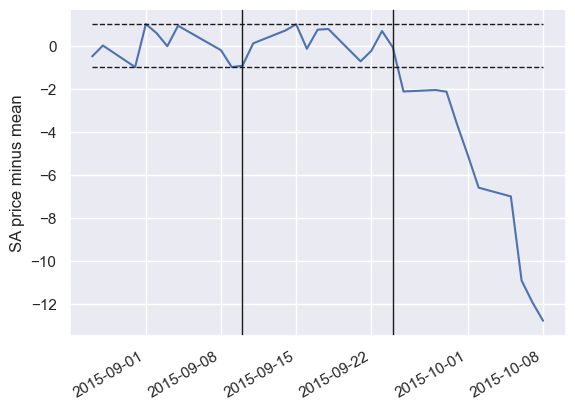

In [75]:
i=17
for group in all_losses_immediate_groups[i:i+1]:
    plot_all_portfolios(group.Arbs.stat_arbs, group.prices_train, group.prices_val, group.prices_test)
    plt.gcf().autofmt_xdate()
    plt.ylabel("SA price minus mean")

# Plot profitable groups

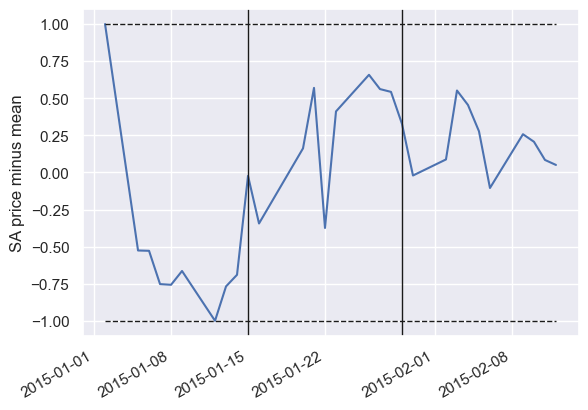

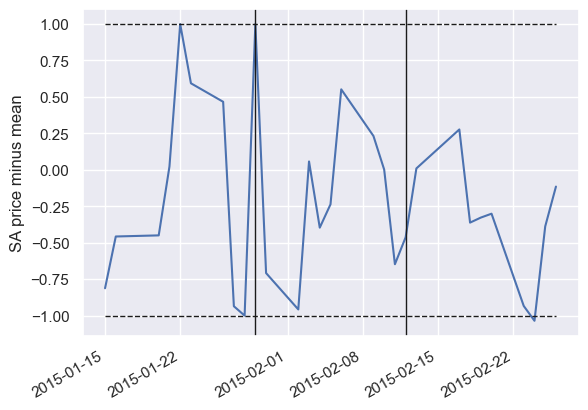

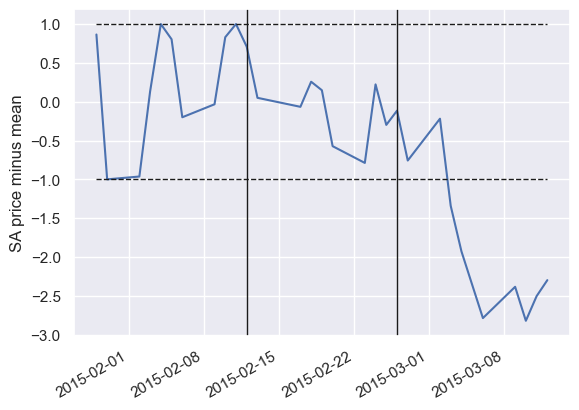

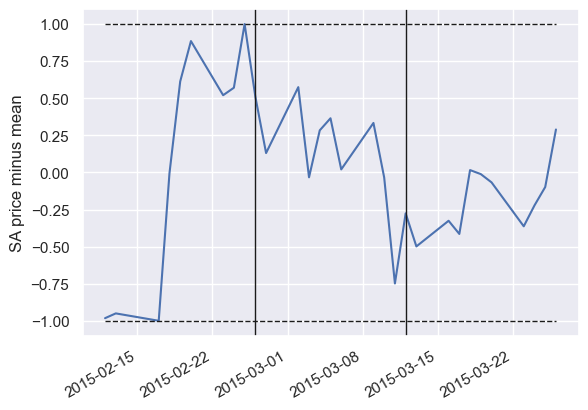

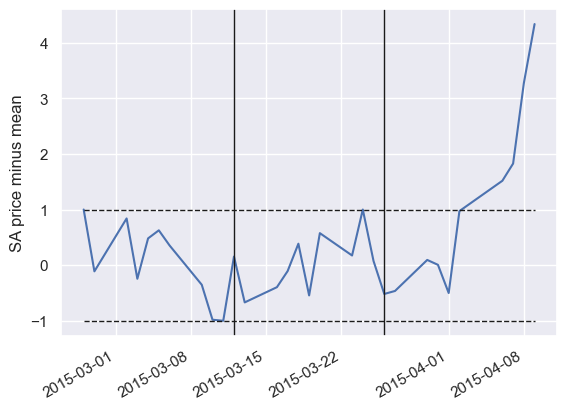

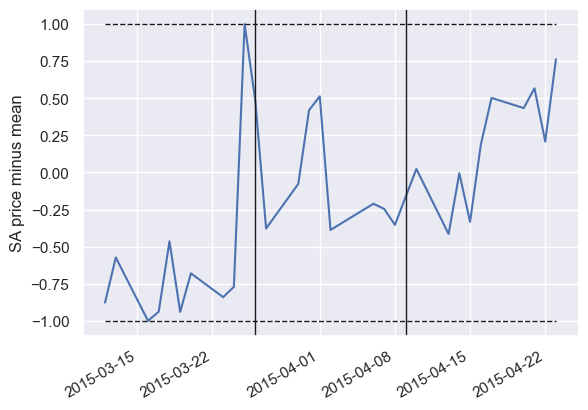

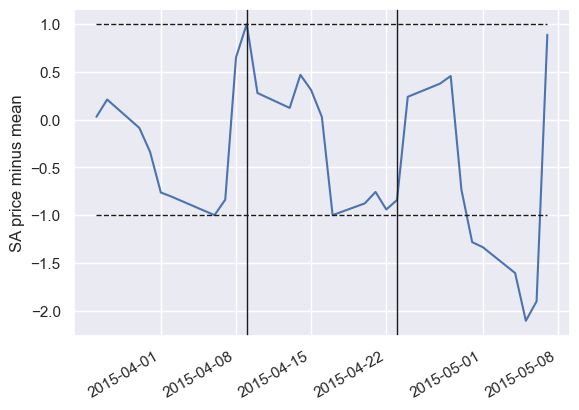

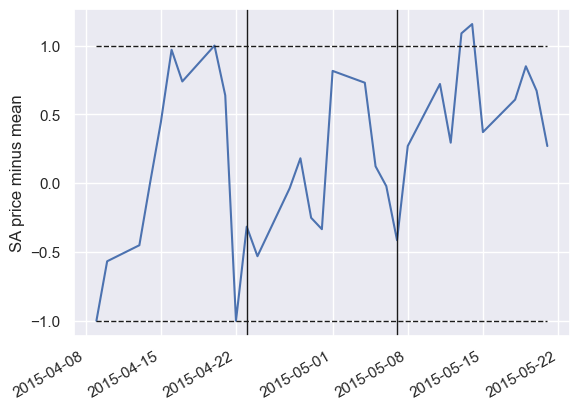

In [84]:
for i in range(8):
    for group in profitable_groups[i:i+1]:
        plt.figure()
        plot_all_portfolios([group.Arbs.stat_arbs[0]], group.prices_train, group.prices_val, group.prices_test)
        plt.gcf().autofmt_xdate()
        plt.ylabel("SA price minus mean")
        plt.savefig(f"/Users/kasper/Documents/Stanford/Research/My papers/stat_arbs/cvx_ccv_stat_arb/paper/figures/profitable_SA_{i}.png")

# Plot unprofitable groups

In [85]:
for i in range(8):
    for group in unprofitable_groups[i:i+1]:
        plt.figure()
        plot_all_portfolios([group.Arbs.stat_arbs[0]], group.prices_train, group.prices_val, group.prices_test)
        plt.gcf().autofmt_xdate()
        plt.ylabel("SA price minus mean")
        # plt.savefig(f"/Users/kasper/Documents/Stanford/Research/My papers/stat_arbs/cvx_ccv_stat_arb/paper/figures/unprofitable_SA_{i}.png")

In [32]:
lens = [len(arb.asset_names) for arb in all_stat_arbs]
lens_validated = [len(arb.asset_names) for arb in all_validated_stat_arbs]

In [33]:
len(all_validated_stat_arbs)

746

In [34]:
for i in lens_validated:
    print(i)

2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
2
2
2
2
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


In [40]:
(np.array(lens_validated)==3).sum()

18

In [41]:
len(lens_validated)

746

In [35]:
np.mean(lens_validated)

2.0241286863270775

In [19]:
np.mean(lens_validated)

2.028263795423957

In [50]:
### Uniform portfolio benchmark
start_date = portfolio.stocks.index[0]
end_date = portfolio.stocks.index[-1]
prices_unif = prices.loc[start_date:end_date]
stocks_unif = pd.DataFrame(np.ones_like(prices_unif)/len(prices_unif.columns), index=prices_unif.index, columns=prices_unif.columns)
portfolio_unif = EquityPortfolio(prices_unif, stocks_unif, initial_cash=portfolio.initial_cash)

In [52]:
m_unif = Metrics(portfolio_unif.profit)
print("profit uniform: ", np.round(m_unif.total_profit,2))
print("SR uniform: ", np.round(m_unif.sr_profit,2))

profit uniform:  113.41
SR uniform:  0.77


In [42]:
m = Metrics(portfolio.profit)
print("profit: ", np.round(m.total_profit,2))
print("SR: ", np.round(m.sr_profit,2))

profit:  45.81
SR:  0.89


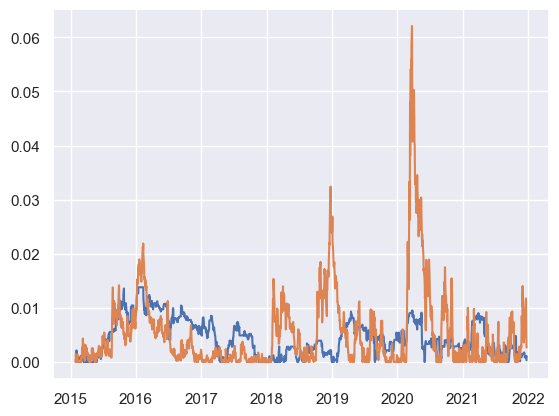

In [55]:
plt.plot(portfolio.drawdown)
plt.plot(portfolio_unif.drawdown)

In [62]:
np.corrcoef(portfolio.nav, portfolio_unif.nav.loc[portfolio.nav.index])

array([[1.        , 0.83214808],
       [0.83214808, 1.        ]])

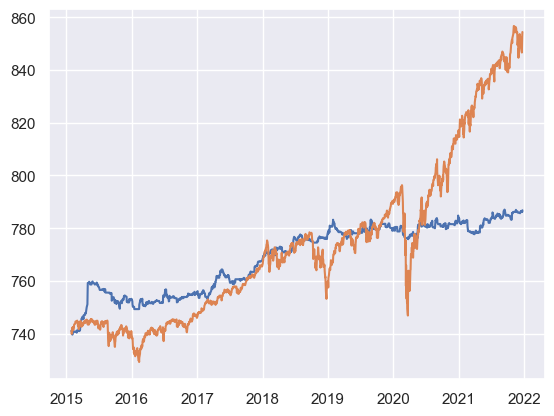

In [53]:
plt.plot(portfolio.nav)
plt.plot(portfolio_unif.nav)

<Axes: xlabel='date'>

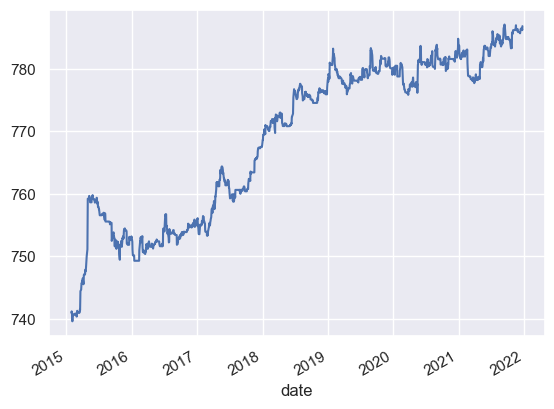

In [43]:
portfolio.nav.plot()

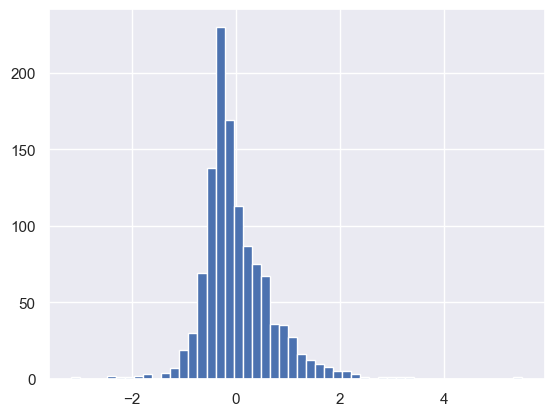

In [29]:
all_total_profits = []
for daily_profit in all_stat_arb_daily_profits:
    all_total_profits.append(daily_profit.sum())
# histogram
plt.hist(all_total_profits, bins=50);

47% profitable


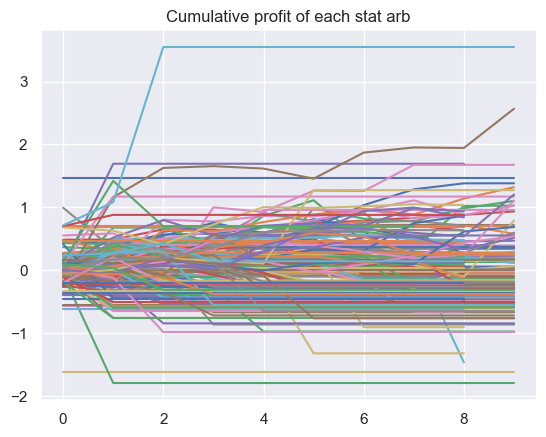

In [352]:
n_profitable = 0
avg_profits = np.zeros(10)
for profit in all_stat_arb_daily_profits:
    plt.plot(profit.cumsum().values)
    if profit.sum() > 0:
        n_profitable += 1
    avg_profits[:len(profit)] += profit
avg_profits /= len(all_stat_arb_daily_profits)
avg_profits[0] = 0
plt.title("Cumulative profit of each stat arb");
print(f"{n_profitable/len(all_stat_arb_daily_profits):.0%} profitable")

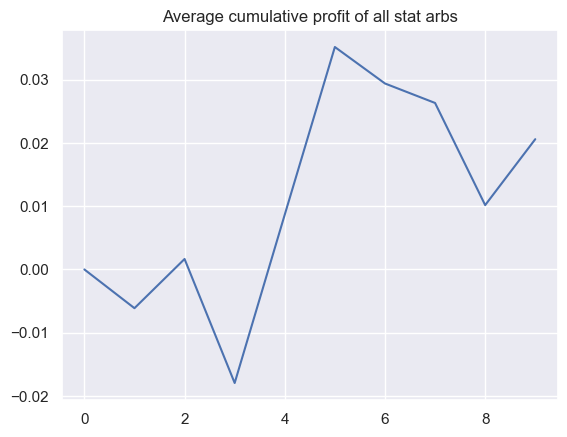

In [319]:
plt.plot(np.cumsum(avg_profits));
plt.title("Average cumulative profit of all stat arbs");

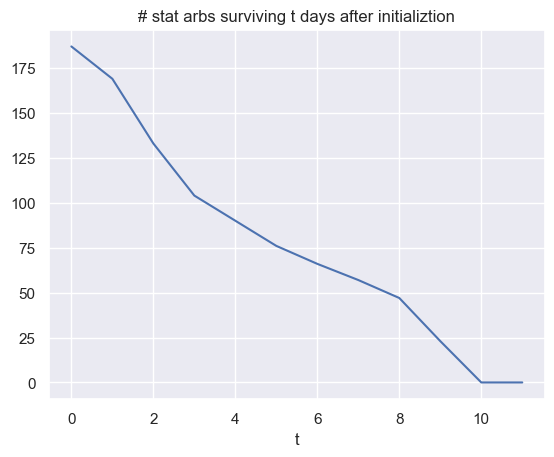

In [320]:
# Find number of survivers as a function of time
n_survivers = []
for i in range(12):
    n = 0
    for profit in all_stat_arb_daily_profits:
        if len(profit) > i:
            if profit[i] !=0:
                n+=1

    n_survivers.append(n)

plt.plot(n_survivers); plt.title("# stat arbs surviving t days after initializtion"); plt.xlabel("t");

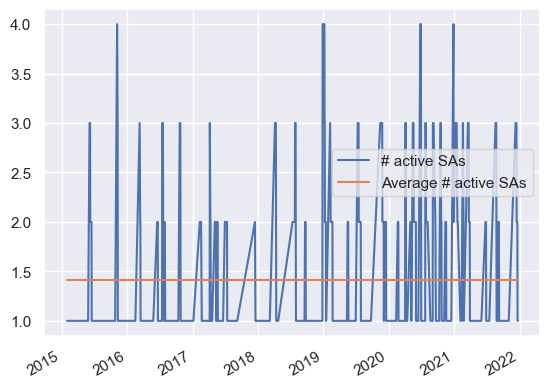

In [321]:
# Find number of active stat arbs at each time step
n_active = {}

for profit in all_stat_arb_daily_profits:
    for i in range(len(profit)):
        if profit[i] != 0:
            if profit.index[i] in n_active:
                n_active[profit.index[i]] += 1
            else:
                n_active[profit.index[i]] = 1

time_steps = list(n_active.keys())
n_active = list(n_active.values())

plt.plot(time_steps, n_active, label="# active SAs");
# plot average active
avg_active = np.mean(n_active)
plt.plot(time_steps, [avg_active]*len(time_steps), label="Average # active SAs")
plt.legend()

plt.gcf().autofmt_xdate();


### Sum portfolios

### Metrics

In [261]:
m = Metrics(portfolio.profit)
print("profit: ", np.round(m.total_profit,2))
print("SR: ", np.round(m.sr_profit,2))

profit:  61.75
SR:  0.72


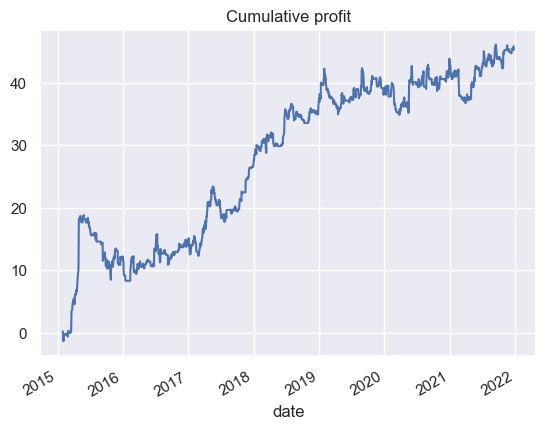

In [229]:
portfolio.profit.cumsum().plot()
plt.title("Cumulative profit");

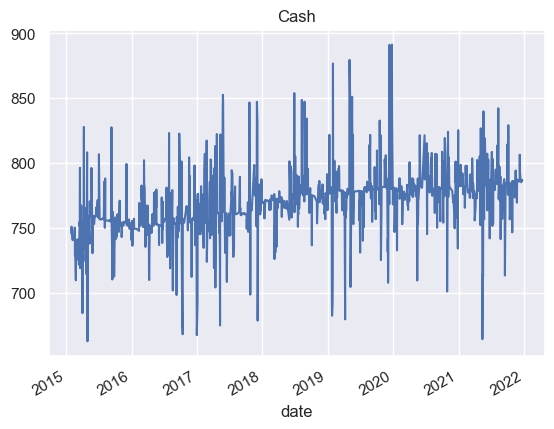

In [191]:
portfolio.cash.plot()
plt.title("Cash");

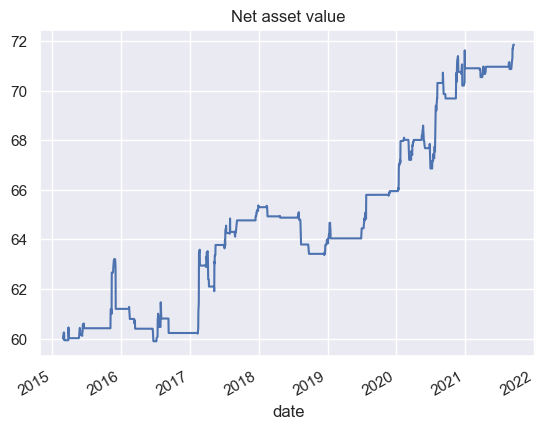

In [146]:
portfolio.nav.plot()
plt.title("Net asset value");

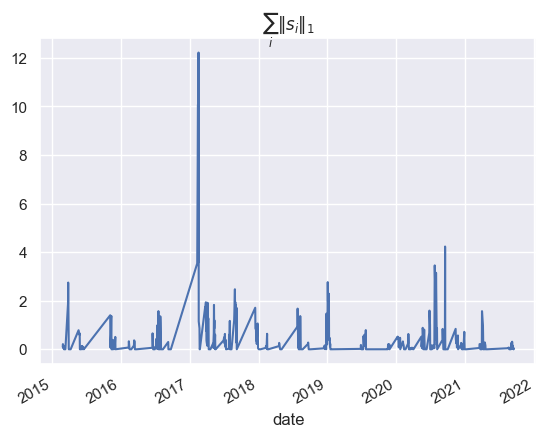

In [147]:
portfolio.stocks.abs().sum(axis=1).plot()
plt.title(r"$\sum_i\|s_i\|_1$");

(-10.0, 10.0)

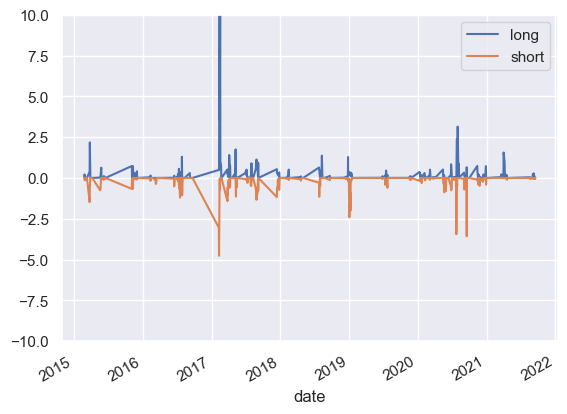

In [149]:
# Plot long positions
portfolio.stocks[portfolio.stocks>0].sum(axis=1).plot(label="long")
portfolio.stocks[portfolio.stocks<0].sum(axis=1).plot(label="short");
plt.legend();
plt.ylim(-10,10)

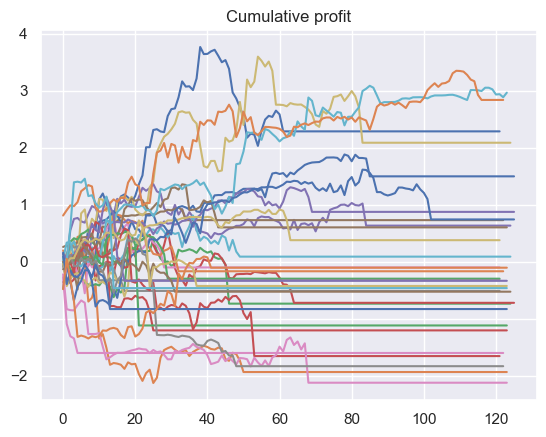

In [139]:
# Individual stat arb groups
for portfolio in all_portfolios:
    if portfolio is not None:
        m = Metrics(portfolio.profit)
        plt.plot(m.daily_profit.cumsum().values)
plt.title("Cumulative profit");